This noteboook is to calculate the chisq values of the fits

In [1]:
#TODO: Object oriented JPN research
#TODO: Make own chi square func

In [2]:
import tensorflow as tf
import zfit
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import math


/opt/anaconda3/envs/m2_req/lib/python3.10/site-packages/zfit/__init__.py:59: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


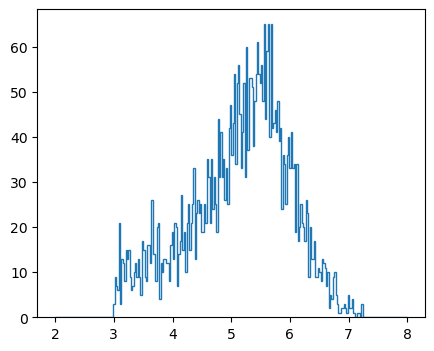

In [3]:
data = zfit.Data.from_root("mu2e_caloSimu_crySpec1345_simEdep.root", "specTree", ["spec", "ratio", "ntrig", "stim", "time", "tErg"]) #importing data from root file
cryspec = zfit.Space(['x'], limits=(3,8)) #observable range:: 1.5 limit is placed in fcl file

energy_unbinned= zfit.Data(data["spec"],obs=cryspec) #zfit.Data is used for unbinned data, obs has to be specified
bin_count = 260 #trivially set depending on what we want the y axis to represent (x evts/kev)
plt.figure(figsize=(5,4))
energy_binned, bin_location, patches = plt.hist(energy_unbinned,bins=bin_count,histtype='step',range=(2,8)) #binning energy values and creating an x array of bin location
bin_centers =  (bin_location[1:] + bin_location[:-1])/2

x_range= cryspec.area() 
scale = (len(energy_unbinned)/bin_count)*x_range #the pdfs are normalised to =1 so must apply scaling factor


#### Parameters for 3 peaks

In [4]:
# defining functions for composed parameters
def frac_res_formula(params):
    return tf.pow((tf.pow(params["a"]/tf.pow((params["peak"]/1000),0.25),2)),0.5) + (params["b"])**2 + (params["c"]/params["peak"])**2

def multiply(params):
    return params["c"]*params["d"]

def subtract(params):
    return params["x"]-params["y"]

def EvnBG_formula(params):
    return params["total"]-params["full"]-params["first"]-params["second"]

In [5]:
ergElec = 0.511  #mass of electron in MeV 
fcbalpha = zfit.Parameter("fcbalpha", 2.5, 0.05, 20.0); # crystal ball constant alpha:: parameter where to switch from a gaussian to the powertail
fcbndeg = zfit.Parameter ("fcbndeg", 10, 0.25, 100); # crystal ball constant n::Exponent of the powertail
A = zfit.Parameter ("A constant", 0.01, 0.005, 1); # coefficient of E(GeV)^1/4
B = zfit.Parameter ("B constant", 0.5, 0.005, 1); # Constant term
C = 0.15 # Electronic noise in MeV
tot_evns = len(energy_unbinned) #total number of events

#Peaks
fullPeak = zfit.Parameter("full peak", 6,4,6.5); 
fstEsPeak = zfit.ComposedParameter("composed fst peak", subtract, params={"x":fullPeak,"y":ergElec})
scdEsPeak = zfit.ComposedParameter("composed scd peak", subtract, params={"x":fullPeak,"y":2*ergElec})

#fractional resolution
fullRes = zfit.ComposedParameter("Composed Full frac Res",frac_res_formula , params = {"a":A, "b":B,"c":C,"peak":fullPeak})
fstRes = zfit.ComposedParameter("Composed First frac Res",frac_res_formula , params = {"a":A, "b":B,"c":C,"peak":fstEsPeak})
scdRes = zfit.ComposedParameter("Composed Second frac Res",frac_res_formula , params = {"a":A, "b":B,"c":C,"peak":scdEsPeak})

#widths 
fullWidth = zfit.ComposedParameter("width of the full peak",multiply,params = {"c":fullPeak,"d":fullRes} )
fstWidth = zfit.ComposedParameter("width of the first peak",multiply,params = {"c":fstEsPeak,"d":fstRes} ) 
scdWidth = zfit.ComposedParameter("width of the second peak",multiply,params = {"c":scdEsPeak,"d":scdRes} )

#number of events in peak
EvnFull = zfit.Parameter("No. of Events in full peak", 500);
EvnFrst = zfit.Parameter("No. of Events in first escape peak", 500);
EvnScd = zfit.Parameter("No. of Events in second escape peak", 500)
EvnBG = zfit.ComposedParameter("Fraction of logistic background",EvnBG_formula, params={"total":tot_evns, "full":EvnFull,"first":EvnFrst,"second":EvnScd})

#logistic background parameters
comCnst = zfit.Parameter("comCnst", 4, 1, 20)
combeta = zfit.Parameter("combeta", 1, 0.01, 30)

#### Logistic background

In [6]:
class bckgrndPDF(zfit.pdf.ZPDF):
    _N_OBS = 1
    _PARAMS = ['comCnst3', 'combeta3']  # the name of the parameters

    def _unnormalized_pdf(self, x):
        x = zfit.z.unstack_x(x)
        comCnst = self.params['comCnst3']
        combeta = self.params['combeta3']
        return 1.0/(1.0+tf.math.exp((x-comCnst)/combeta))

In [7]:
fullErg = zfit.pdf.CrystalBall(obs=cryspec, mu=fullPeak, sigma=fullWidth, alpha=fcbalpha, n=fcbndeg, extended=EvnFull)
firstErg = zfit.pdf.CrystalBall(obs=cryspec,mu=fstEsPeak,sigma=fstWidth,alpha=fcbalpha, n=fcbndeg, extended=EvnFrst)
secdErg = zfit.pdf.CrystalBall(obs=cryspec, mu=scdEsPeak, sigma=scdWidth, alpha=fcbalpha, n=fcbndeg, extended=EvnScd)
background = bckgrndPDF(obs=cryspec, comCnst3=comCnst,combeta3=combeta, extended = EvnBG)
comb_fit = zfit.pdf.SumPDF([fullErg,firstErg,secdErg],obs=cryspec,extended = True)

y_plot_full = fullErg.pdf(bin_centers,norm_range=cryspec)
y_plot_first = firstErg.pdf(bin_centers,norm_range=cryspec)
y_plot_secd = secdErg.pdf(bin_centers,norm_range=cryspec)
y_plot_comb = comb_fit.pdf(bin_centers,norm_range=cryspec)
y_plot_logistic = background.pdf(bin_centers,norm_range=cryspec)

In [8]:
nll_comb = zfit.loss.ExtendedUnbinnedNLL(model=comb_fit, data=energy_unbinned)#, constraints=constraint)

minimizer = zfit.minimize.Minuit()

result = minimizer.minimize(nll_comb, params=[A,B,fcbalpha,fcbndeg,
                                                  fullPeak,EvnFull,
                                                  EvnFrst,EvnScd,
                                                  comCnst,combeta])

In [9]:
y_plot_full = fullErg.pdf(bin_centers,norm_range=cryspec)
y_plot_first = firstErg.pdf(bin_centers,norm_range=cryspec)
y_plot_secd = secdErg.pdf(bin_centers,norm_range=cryspec)
y_plot_comb = comb_fit.pdf(bin_centers,norm_range=cryspec)
#y_plot_logistic = background.pdf(bin_centers,norm_range=cryspec)

In [10]:
# combining binned data so that atleast 7 data points in each bin
combined_bins = []
current_bin = []

combined_edges = []
current_edge = []
left_edge = []
temp_bin = []
for (i,j) in zip(energy_binned,bin_location):
    current_bin.append(i)
    current_edge.append(j)

    if sum(current_bin)>=7:
        combined_bins.append(sum(current_bin[:]))
        combined_edges.append(current_edge.pop(0))
        current_edge.clear()
        current_bin.clear()
#if current_bin:
#    combined_bins.append(sum(current_bin[:])) 
#    combined_edges.append(current_edge.pop(0))
#    current_edge.clear()
#    current_bin.clear()

##need to make this code such that the last data point is emitted because it is 0. 

In [11]:
#scale_combined = (np.array(combined_bins)/len(combined_bins))
#scale_combined needs to be an array
#print(x_range)
#print(len(combined_bins))
#print(combined_bins)


In [12]:
#from hepstats.hypotests import Discovery

In [13]:
# simple chi square calculation using (comb_fit-binned_data)^2/binned_data
y_plot_comb_combedges = comb_fit.pdf(combined_edges,norm_range=cryspec)

chi_sq = np.sum(((y_plot_comb_combedges*scale)-(combined_bins))**2/(combined_bins))

ndf = len(combined_edges)-10-1 #-1 because we are looking at edges, so there is one extra edge than bins
print(chi_sq)
print(ndf)
print(chi_sq/ndf)
#print(chi_sq_simple/ndf) #specifiy chi sq and ndf
## need to find pvalue-- zfit has pvalue func but can look online for relationship -- est pval would. be small bc this is a bad fit
#intergral over bins to get more accurate result-- instead of bin edges
#scaling factor needs to change to (height of combined bins/ # of data in the bins)
#3700 = 2.0 -> 8.0
#3900 = 1.5 -> 8.0

329.15409377289166
149
2.209087877670414


Text(0.5, 1.0, 'Chi Sq. Difference ')

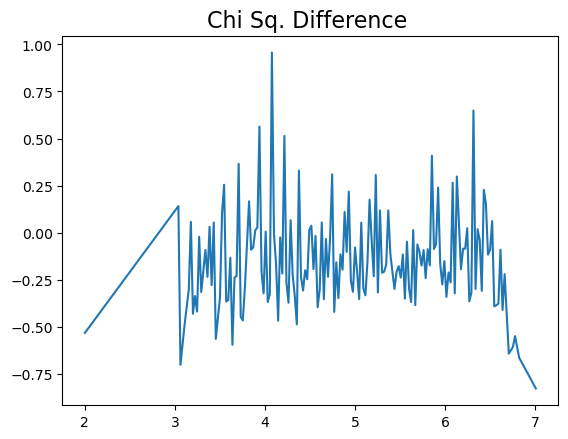

In [14]:
#plt.plot(combined_edges, y_plot_comb_combedges*scale)
#plt.plot(combined_edges, combined_bins)
plt.plot(combined_edges, ((y_plot_comb_combedges*scale)-(combined_bins))/combined_bins)
plt.title("Chi Sq. Difference ", fontsize=16)
#print(len(combined_bins))
#to get more info find the sign of each bin

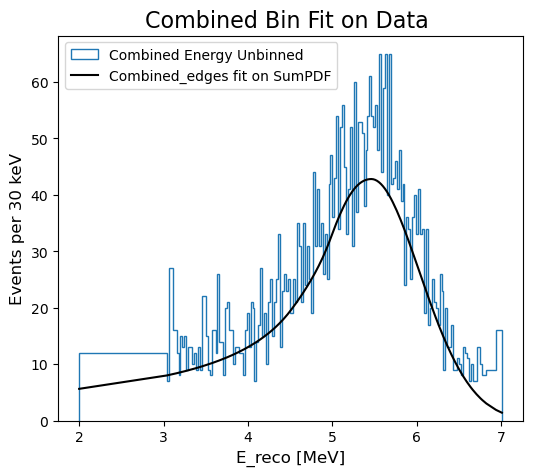

In [15]:
# plotting combined bin with the pdf to get a visual 
fig, ax = plt.subplots(1,1,figsize=(6,5))
plt.hist(combined_edges,bins=(combined_edges),weights=combined_bins,histtype='step',label= 'Combined Energy Unbinned')
#plt.plot(combined_edges,y_plot_comb_combbins*scale,label="Combined_bins fit on SumPDF")
plt.plot(combined_edges, y_plot_comb_combedges*scale,color="black", label='Combined_edges fit on SumPDF')
#plt.plot(bin_centers, y_plot_comb*scale,color="red", label='Full Peak CB')

plt.title("Combined Bin Fit on Data ", fontsize=16)
plt.ylabel('Events per 30 keV',fontsize=12)
plt.xlabel('E_reco [MeV]',fontsize=12)
leg = plt.legend(fontsize=10);

### P-value Test

In [16]:
import scipy
p_value = scipy.stats.chi2.sf(chi_sq,ndf)
print(p_value)

1.251142094464542e-15


### Residual

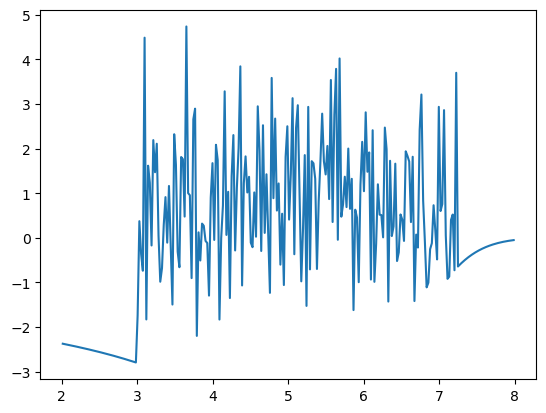

In [17]:
residual = (energy_binned-y_plot_comb*scale)/np.sqrt(y_plot_comb*scale)
plt.plot(bin_centers,residual)

### Normalised Residuals

[Text(0.5, 0, 'E_reco [MeV]'), Text(0, 0.5, 'Events per 25 keV')]

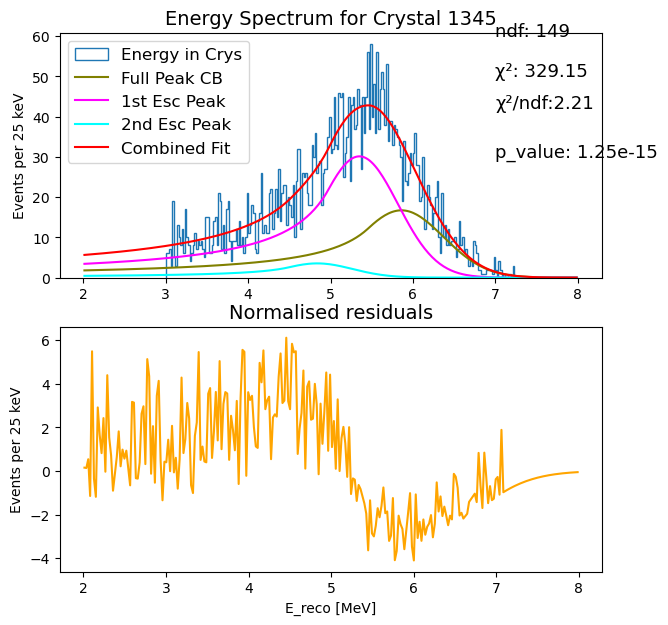

In [20]:
fig, (ax,ax2) = plt.subplots(2,1,figsize=(7,7))
energy_binned, bin_location, patches = ax.hist(energy_unbinned,
                           bins=(bin_count),histtype='step',
                           range=(3,8), label= "Energy in Crys")
ax.plot(bin_centers, y_plot_full*scale*EvnFull/len(energy_unbinned), color="olive", label='Full Peak CB')
ax.plot(bin_centers, y_plot_first*scale*EvnFrst/len(energy_unbinned), color="magenta",label='1st Esc Peak')
ax.plot(bin_centers, y_plot_secd*scale*EvnScd/len(energy_unbinned), color="cyan",label='2nd Esc Peak')
#logistic background
#ax.plot(bin_centers, y_plot_logistic*scale*EvnBG/len(energy_unbinned), color="black", label='Logistic Bg')

#Combined Fit
ax.plot(bin_centers, y_plot_comb*scale, color="red",label='Combined Fit')
ax.text(7,60,"ndf: "+str(round(ndf,2)),fontsize=13)
ax.text(7,50,"\u03C7\u00B2: "+str(round(chi_sq,2)),fontsize=13)
ax.text(7,42,"\u03C7\u00B2/ndf:"+str(round((chi_sq/ndf),2)),fontsize=13)
ax.text(7,30,"p_value: "+str(format(p_value,'0.2e')),fontsize=13)

ax.set_title("Energy Spectrum for Crystal 1345", fontsize=14)
ax.set( ylabel='Events per 25 keV')#,fontsize=12)
#ax.xlabel('E_reco [MeV]',fontsize=12)
leg = ax.legend(fontsize=12);

ax2.plot(bin_centers,residual,color = 'orange')
ax2.set_title("Normalised residuals", fontsize=14)
ax2.set(xlabel='E_reco [MeV]', ylabel='Events per 25 keV')


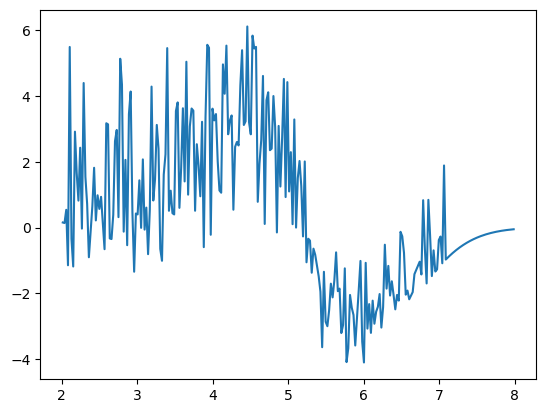

In [19]:
residual = (energy_binned-y_plot_comb*scale)/np.sqrt(y_plot_comb*scale)
plt.plot(bin_centers,residual)